In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import uniform, beta, norm, bernoulli
from random import seed
from tqdm import trange
import itertools
from scipy import stats
from numba import njit, prange
from numba.typed import List
import time

In [2]:
np.random.seed(42)
x0 = uniform.rvs(loc=0, scale=1, size=100)

In [49]:
def HK(x, eps):
    N = len(x)
    neighbours = [[] for _ in range(len(x))]
    next_x = []
    for i in range(N):
        for j in range(N):
            if abs(x[i] - x[j]) <= eps:
                neighbours[i].append(x[j])
        next_x.append(1 / len(neighbours[i]) * np.sum(neighbours[i]))
    return np.array(next_x)

def next_state_HK(x, eps, maxit):
    states = []
    for i in range(maxit):
        x = HK(x, eps)
        states.append(x)
    return states

In [51]:
def additive_noise(x, eps, alpha1, alpha2):
    ksi1 = uniform.rvs(size=len(x), loc=0, scale=0.5)
    ksi2 = uniform.rvs(size=len(x), loc=0.5, scale=0.5)
    next_x = alpha1 * ksi1 + alpha2 * ksi2 + (1-alpha1-alpha2) * HK(x, eps)
    return next_x

def next_state_additive_noise(x0, eps, alpha1, alpha2, maxit):
    x = []
    x.append(x0)
    for _ in range(maxit-1):
        x.append(additive_noise(x[-1], eps, alpha1, alpha2))
    return np.array(x)

In [23]:
def deterministic_additive_noise_j(x, j, eps, alpha1, alpha2, m, h):
    h1, h2 = h
    alpha = 1 - alpha1 - alpha2
    next_x = np.zeros(len(x))
    ksi1 = uniform.rvs(size=len(x), loc=0, scale=0.5)
    ksi2 = uniform.rvs(size=len(x), loc=0.5, scale=0.5)
    next_x[j] = alpha * HK(x, eps)[j] + alpha1 * ksi1[j] + alpha2 * ksi2[j]
    for var in deterministic:
        if j == var:
            next_x[j] = alpha * HK(x, eps)[j] + alpha1 * h1 + alpha2 * h2
    return next_x[j]

def deterministic_additive_noise(x, eps, alpha1, alpha2, m, h):
    next_x = []
    for i in range(len(x)):
        next_x.append(deterministic_additive_noise_j(x, i, eps, alpha1, alpha2, m, h))
    return next_x

def next_state_deterministic_additive_noise(x0, eps, alpha1, alpha2, m, h, maxit):
    x = []
    x.append(x0)
    for _ in trange(maxit-1):
        x.append(deterministic_additive_noise(x[-1], eps, alpha1, alpha2, m, h))
    return np.array(x)

In [ ]:
def stubborn_additive_noise_j(x, j, eps, alpha1, alpha2, m, h):
    alpha = 1 - alpha1 - alpha2
    next_x = np.zeros(len(x))
    ksi1 = uniform.rvs(size=len(x), loc=0, scale=0.5)
    ksi2 = uniform.rvs(size=len(x), loc=0.5, scale=0.5)
    next_x[j] = alpha * HK(x, eps)[j] + alpha1 * ksi1[j] + alpha2 * ksi2[j]
    if j in stubborn:
        next_x[j] = h
    return next_x[j]

def stubborn_additive_noise(x, eps, alpha1, alpha2, m, h):
    next_x = []
    for i in range(len(x)):
        next_x.append(stubborn_additive_noise_j(x, i, eps, alpha1, alpha2, m, h))
    return next_x

def next_state_stubborn_additive_noise(x0, eps, alpha1, alpha2, m, h, maxit):
    x = []
    x.append(x0)
    for _ in trange(maxit-1):
        x.append(stubborn_additive_noise(x[-1], eps, alpha1, alpha2, m, h))
    return np.array(x)

In [ ]:
def stubborn_additive_noise_j_new(x, j, eps, alpha1, alpha2, m, h):
    h1, h2 = h
    alpha = 1 - alpha1 - alpha2
    next_x = np.zeros(len(x))
    ksi1 = uniform.rvs(size=len(x), loc=0, scale=0.5)
    ksi2 = uniform.rvs(size=len(x), loc=0.5, scale=0.5)
    next_x[j] = alpha * HK(x, eps)[j] + alpha1 * ksi1[j] + alpha2 * ksi2[j]
    if j in stubborn1:
        next_x[j] = h1
    if j in stubborn2:
        next_x[j] = h2
    return next_x[j]

def stubborn_additive_noise_new(x, eps, alpha1, alpha2, m, h):
    next_x = []
    for i in range(len(x)):
        next_x.append(stubborn_additive_noise_j_new(x, i, eps, alpha1, alpha2, m, h))
    return next_x

def next_state_stubborn_additive_noise_new(x0, eps, alpha1, alpha2, m, h, maxit):
    x = []
    x.append(x0)
    for _ in trange(maxit-1):
        x.append(stubborn_additive_noise_new(x[-1], eps, alpha1, alpha2, m, h))
    return np.array(x)

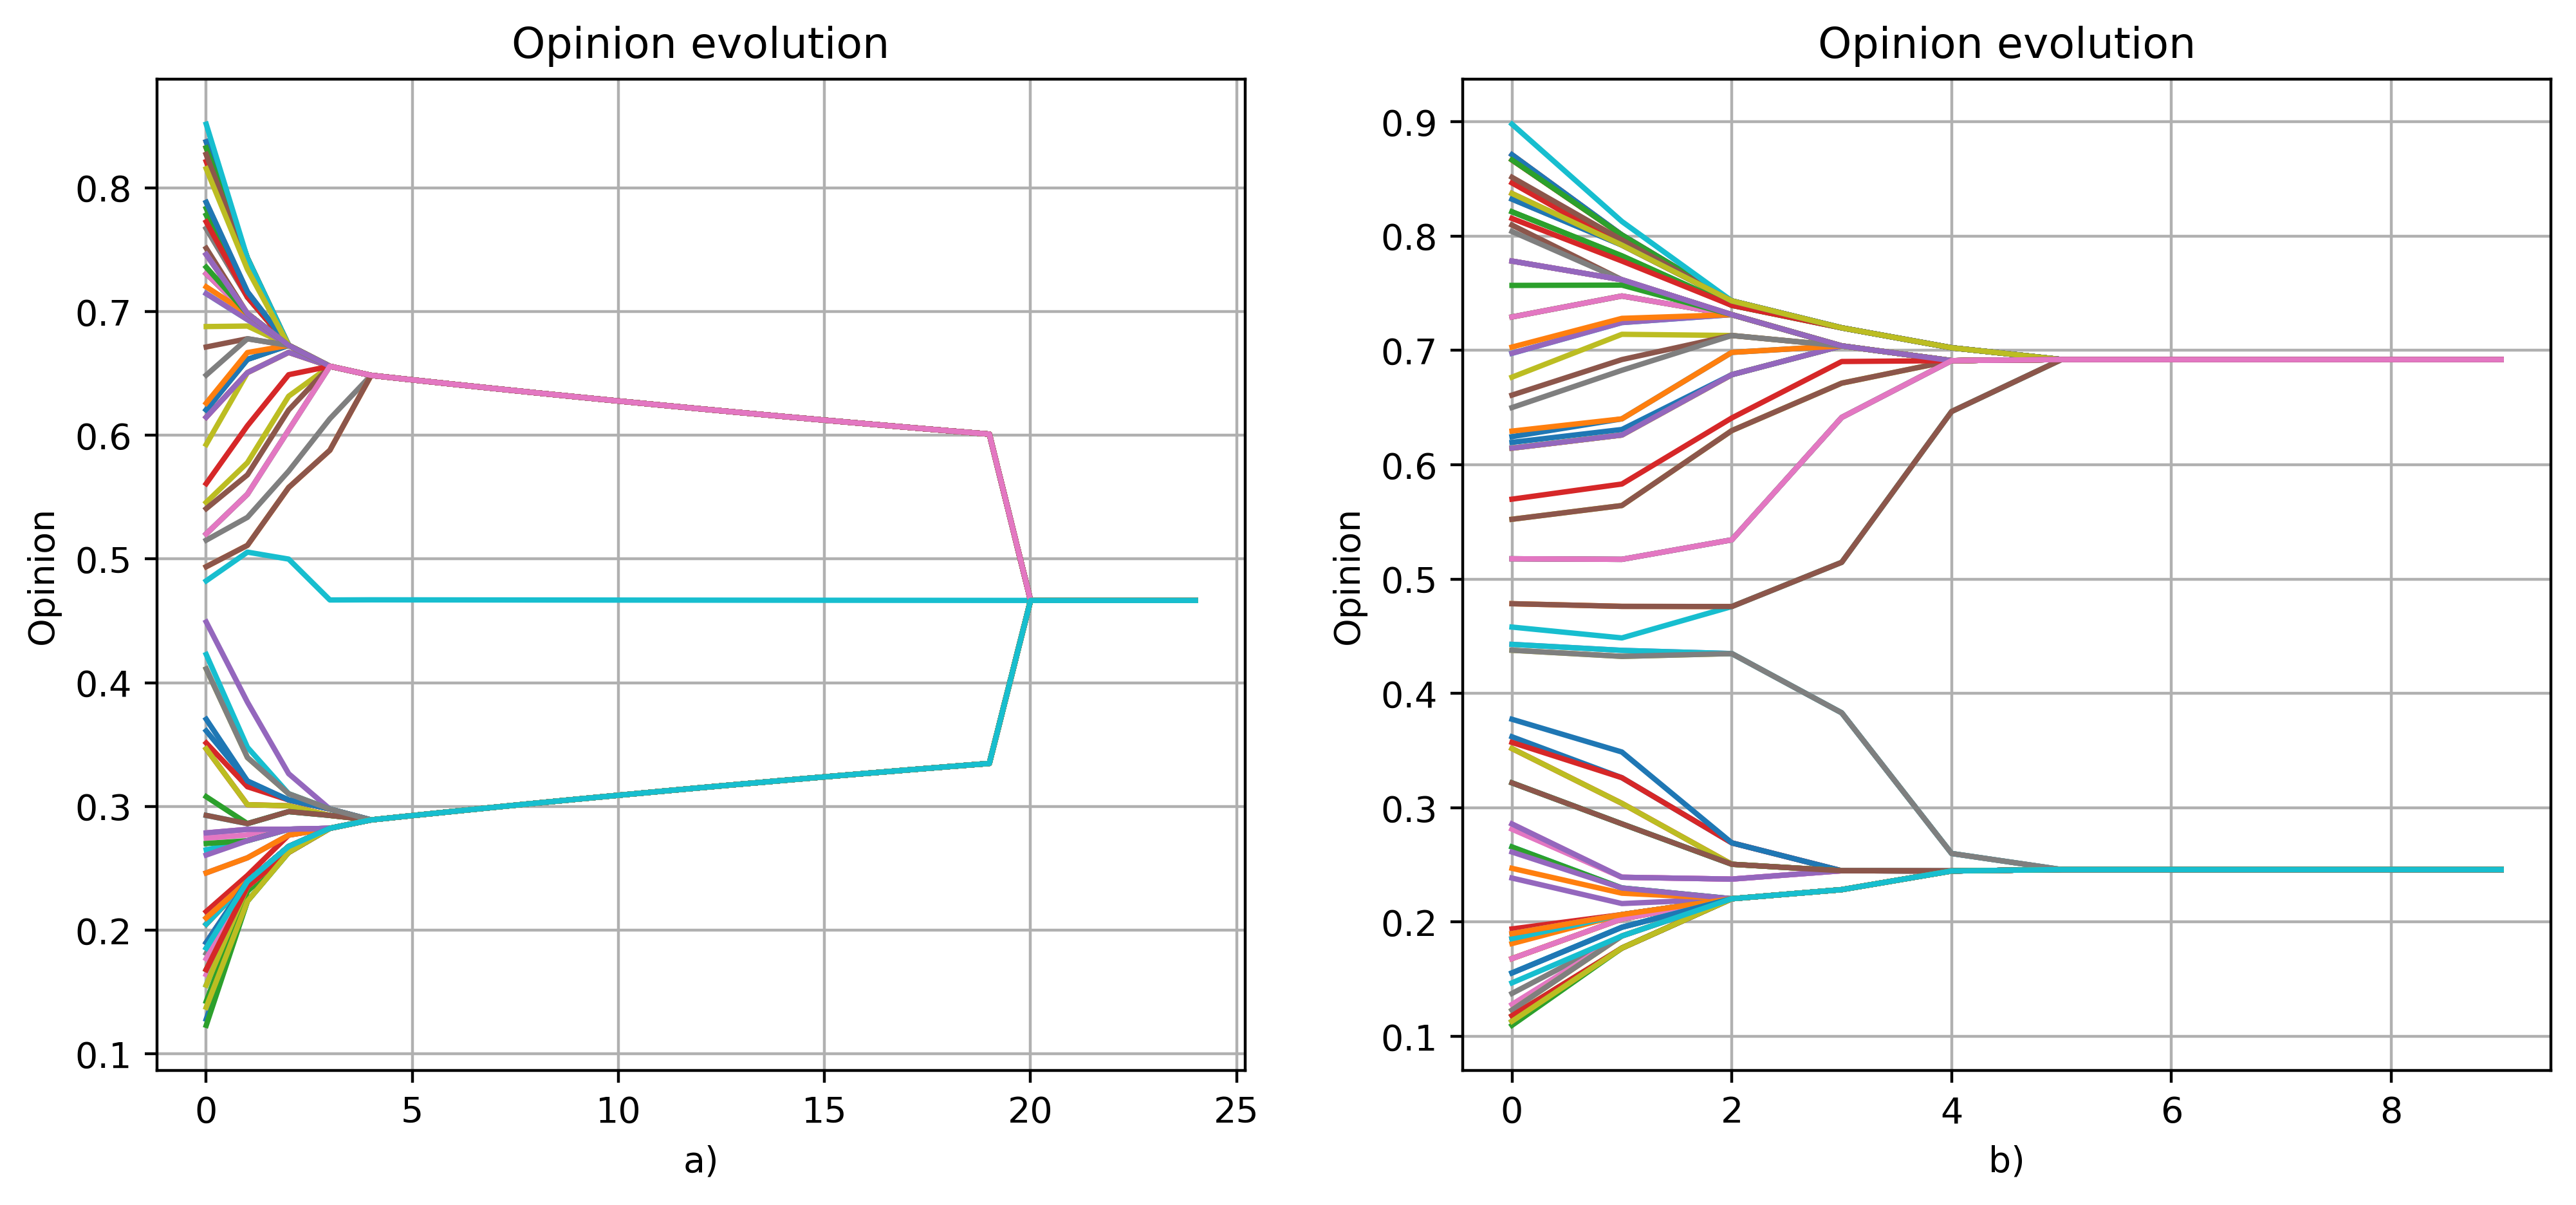

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=400)
plt.subplots_adjust(hspace=0.5)
ax[0].plot(next_state_HK(x0, 0.27, 25))
ax[1].plot(next_state_HK(x0, 0.2, 10))
for i in range(2):
    ax[i].grid(True)
    ax[i].set_ylabel('Opinion')
ax[0].set_xlabel('a)')
ax[1].set_xlabel('b)')
ax[0].set_title('Opinion evolution')
ax[1].set_title('Opinion evolution')
plt.show()

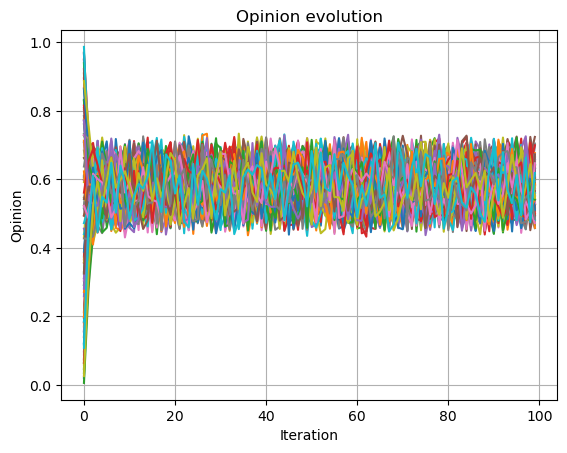

In [72]:
plt.plot(next_state_additive_noise(x0, 0.2, 0.2, 0.4, 100))
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Opinion')
plt.title('Opinion evolution')
plt.show()

In [55]:
# fig, ax = plt.subplots(1, 2, figsize=(9, 4))
# m = 10
# deterministic = random.sample(range(len(x0)), m)
# ax[0].plot(next_state_deterministic_additive_noise(x0, 0.2, 0.2, 0.2, m, [3/4, 1/4], 100), '.', c='grey', alpha=0.1)
# ax[1].plot(next_state_deterministic_additive_noise(x0, 0.2, 0.2, 0.2, m, [3/4, 1/4], 100))
# for i in range(2):
#     ax[i].grid()
#     ax[i].set_xlabel('Iteration')
#     ax[i].set_ylabel('Opinion')
#     ax[i].set_title('Opinion evolution')
# plt.show()

In [56]:
# fig, ax = plt.subplots(1, 2, figsize=(9, 4))
# m = 50
# deterministic = random.sample(range(len(x0)), m)
# ax[0].plot(next_state_deterministic_additive_noise(x0, 0.2, 0.2, 0.2, m, [3/4, 1/4], 100), '.', c='grey', alpha=0.1)
# ax[1].plot(next_state_deterministic_additive_noise(x0, 0.2, 0.2, 0.2, m, [3/4, 1/4], 100))
# for i in range(2):
#     ax[i].grid()
#     ax[i].set_xlabel('Iteration')
#     ax[i].set_ylabel('Opinion')
#     ax[i].set_title('Opinion evolution')
# plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [05:58<00:00,  3.62s/it]


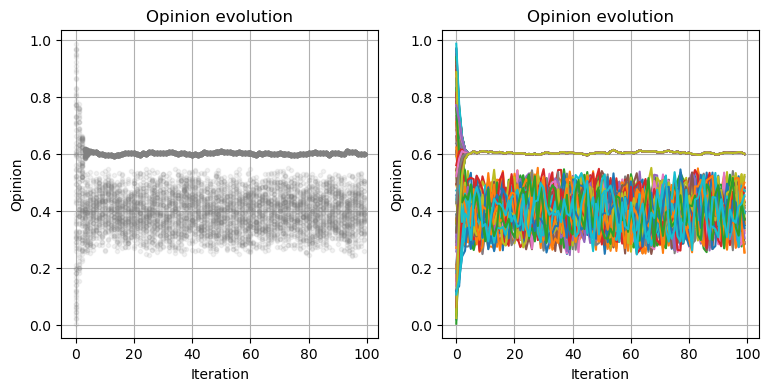

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
m = 50
deterministic = random.sample(range(len(x0)), m)
ax[0].plot(next_state_deterministic_additive_noise(x0, 0.2, 0.4, 0.1, m, [3/4, 1/4], 100), '.', c='grey', alpha=0.1)
ax[1].plot(next_state_deterministic_additive_noise(x0, 0.2, 0.4, 0.1, m, [3/4, 1/4], 100))
for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel('Iteration')
    ax[i].set_ylabel('Opinion')
    ax[i].set_title('Opinion evolution')
plt.show()

In [57]:
# fig, ax = plt.subplots(1, 2, figsize=(9, 4))
# m = 25
# deterministic = random.sample(range(len(x0)), m)
# ax[0].plot(next_state_deterministic_additive_noise(x0, 0.2, 0.05, 0.05, m, [3/4, 1/4], 100), '.', c='grey', alpha=0.1)
# ax[1].plot(next_state_deterministic_additive_noise(x0, 0.2, 0.05, 0.05, m, [3/4, 1/4], 100))
# for i in range(2):
#     ax[i].grid()
#     ax[i].set_xlabel('Iteration')
#     ax[i].set_ylabel('Opinion')
#     ax[i].set_title('Opinion evolution')
# plt.show()

<!-- $\varepsilon=0.2, \alpha^0=0.98, \alpha^1=0.01, \alpha^1=0.01, m=50, h=0.55$ -->

In [58]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# m = 50
# stubborn = random.sample(range(len(x0)), m)
# ax[0].plot(next_state_stubborn_additive_noise(x0, 0.2, 0.01, 0.01, 50, 0.55, 100))
# ax[1].plot(next_state_additive_noise(x0, 0.2, 0.01, 0.01, 100))
# for i in range(2):
#     ax[i].grid(True)
#     ax[i].set_xlabel('Iteration')
#     ax[i].set_ylabel('Opinion')
#     ax[i].set_title('Opinion evolution')
# plt.show()

<!-- $\varepsilon=0.2, \alpha^0=0.8, \alpha^1=0.1, \alpha^1=0.1, m=50, h=0.45$ -->

In [59]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# m = 50
# stubborn = random.sample(range(len(x0)), m)
# ax[0].plot(next_state_stubborn_additive_noise(x0, 0.2, 0.1, 0.1, 50, 0.45, 100))
# ax[1].plot(next_state_additive_noise(x0, 0.2, 0.1, 0.1, 100))
# for i in range(2):
#     ax[i].grid(True)
#     ax[i].set_xlabel('Iteration')
#     ax[i].set_ylabel('Opinion')
#     ax[i].set_title('Opinion evolution')
# plt.show()

<!-- $\varepsilon=0.2, \alpha^0=0.8, \alpha^1=0.1, \alpha^1=0.1, m=50, h=0.25$ -->

In [60]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# m = 50
# stubborn = random.sample(range(len(x0)), m)
# ax[0].plot(next_state_stubborn_additive_noise(x0, 0.2, 0.1, 0.1, 50, 0.25, 100))
# ax[1].plot(next_state_additive_noise(x0, 0.2, 0.1, 0.1, 100))
# for i in range(2):
#     ax[i].grid(True)
#     ax[i].set_xlabel('Iteration')
#     ax[i].set_ylabel('Opinion')
#     ax[i].set_title('Opinion evolution')
# plt.show()

<!-- $\varepsilon=0.2, \alpha^0=0.4, \alpha^1=0.3, \alpha^2=0.3, m=50, h=0.2$ -->

In [63]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# m = 50
# stubborn = random.sample(range(len(x0)), m)
# ax[0].plot(next_state_stubborn_additive_noise(x0, 0.2, 0.3, 0.3, 50, 0.2, 100))
# ax[1].plot(next_state_additive_noise(x0, 0.2, 0.3, 0.3, 100))
# for i in range(2):
#     ax[i].grid(True)
#     ax[i].set_xlabel('Iteration')
#     ax[i].set_ylabel('Opinion')
#     ax[i].set_title('Opinion evolution')
# plt.show()

<!-- $\varepsilon=0.2, \alpha^0=0.8, \alpha^1=0.1, \alpha^2=0.1, m=98, h=0.3$ -->

In [62]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# m = 98
# stubborn = random.sample(range(len(x0)), m)
# ax[0].plot(next_state_stubborn_additive_noise(x0, 0.2, 0.1, 0.1, 98, 0.3, 100))
# ax[1].plot(next_state_additive_noise(x0, 0.2, 0.1, 0.1, 100))
# for i in range(2):
#     ax[i].grid(True)
#     ax[i].set_xlabel('Iteration')
#     ax[i].set_ylabel('Opinion')
#     ax[i].set_title('Opinion evolution')
# plt.show()

<!-- $\varepsilon=0.2,\alpha^0=0.8, \alpha^1=0.1,\alpha^2=0.1, m=10, h=0.2$ -->

In [61]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# m = 10
# stubborn = random.sample(range(len(x0)), m)
# ax[0].plot(next_state_stubborn_additive_noise(x0, 0.2, 0.1, 0.1, 2, 0.2, 100))
# ax[1].plot(next_state_additive_noise(x0, 0.2, 0.1, 0.1, 100))
# for i in range(2):
#     ax[i].grid(True)
#     ax[i].set_xlabel('Iteration')
#     ax[i].set_ylabel('Opinion')
#     ax[i].set_title('Opinion evolution')
# plt.show()

<!-- $\varepsilon=0.2,\alpha^0=0.8, \alpha^1=0.1,\alpha^2=0.1, m=20, h=0.2$ -->

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [03:55<00:00,  2.37s/it]


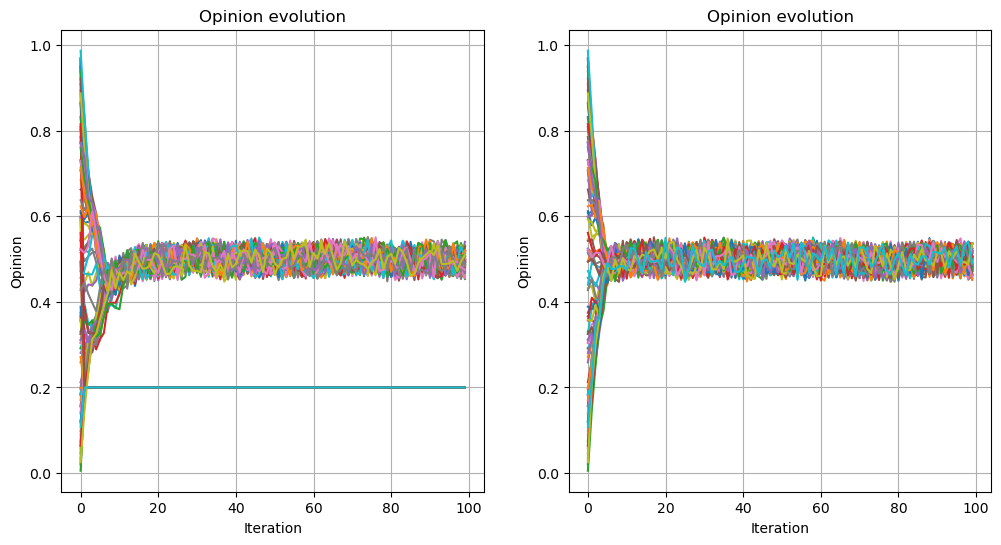

In [109]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
m = 20
stubborn = random.sample(range(len(x0)), m)
ax[0].plot(next_state_stubborn_additive_noise(x0, 0.2, 0.1, 0.1, 2, 0.2, 100))
ax[1].plot(next_state_additive_noise(x0, 0.2, 0.1, 0.1, 100))
for i in range(2):
    ax[i].grid(True)
    ax[i].set_xlabel('Iteration')
    ax[i].set_ylabel('Opinion')
    ax[i].set_title('Opinion evolution')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [03:56<00:00,  2.39s/it]


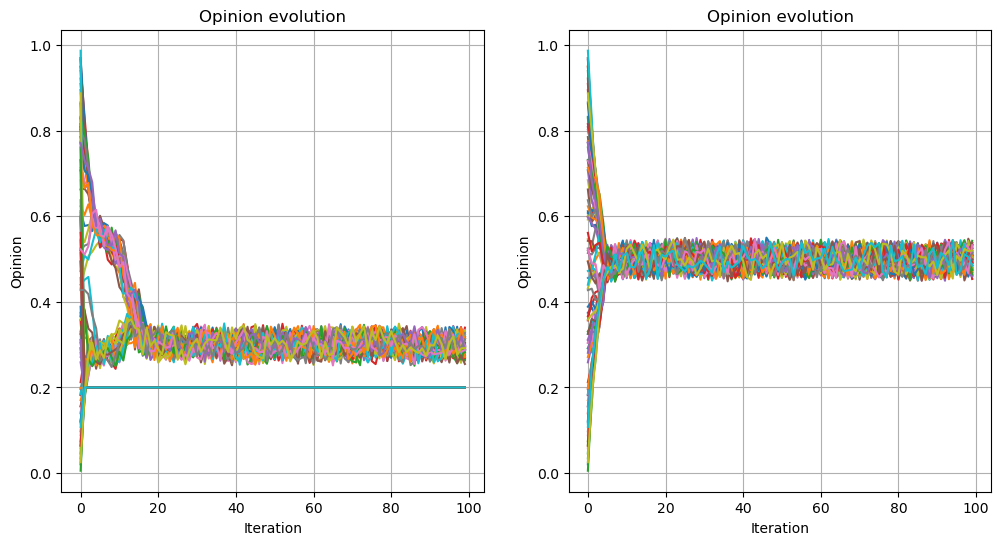

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
m = 50
stubborn = random.sample(range(len(x0)), m)
ax[0].plot(next_state_stubborn_additive_noise(x0, 0.2, 0.1, 0.1, 2, 0.2, 100))
ax[1].plot(next_state_additive_noise(x0, 0.2, 0.1, 0.1, 100))
for i in range(2):
    ax[i].grid(True)
    ax[i].set_xlabel('Iteration')
    ax[i].set_ylabel('Opinion')
    ax[i].set_title('Opinion evolution')
plt.show()

$\varepsilon=0.1, \alpha^0=0.8, \alpha^1=0.1, \alpha^2=0.1, m=50, h=0.2$

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [03:52<00:00,  2.35s/it]


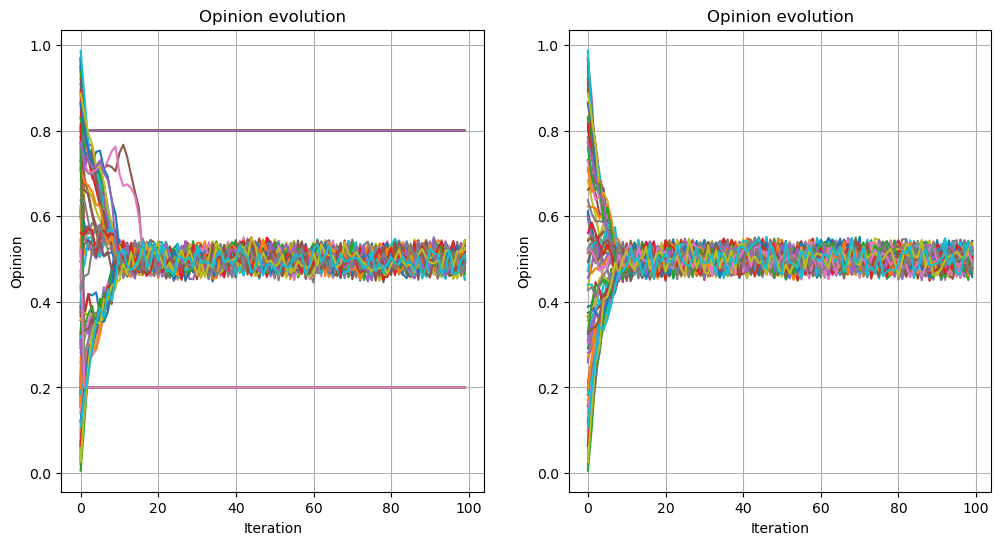

In [112]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
m = 50
stubborn1 = random.sample(range(len(x0)), 25)
for_stubborn = []
for i in range(len(stubborn1)):
    if stubborn1[i] not in x0:
        for_stubborn.append(i)
stubborn2 = random.sample(range(len(for_stubborn)), 25)
ax[0].plot(next_state_stubborn_additive_noise_new(x0, 0.1, 0.1, 0.1, m, [0.2, 0.8], 100))
ax[1].plot(next_state_additive_noise(x0, 0.1, 0.1, 0.1, 100))
for i in range(2):
    ax[i].grid(True)
    ax[i].set_xlabel('Iteration')
    ax[i].set_ylabel('Opinion')
    ax[i].set_title('Opinion evolution')
plt.show()

In [64]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# m = 50
# stubborn = random.sample(range(len(x0)), m)
# ax[0].plot(next_state_stubborn_additive_noise(x0, 0.1, 0.1, 0.1, m, 0.2, 100))
# ax[1].plot(next_state_additive_noise(x0, 0.1, 0.1, 0.1, 100))
# for i in range(2):
#     ax[i].grid(True)
#     ax[i].set_xlabel('Iteration')
#     ax[i].set_ylabel('Opinion')
#     ax[i].set_title('Opinion evolution')
# plt.show()

In [65]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# m = 70
# stubborn = random.sample(range(len(x0)), m)
# ax[0].plot(next_state_stubborn_additive_noise(x0, 0.1, 0.1, 0.1, m, 0.2, 100))
# ax[1].plot(next_state_additive_noise(x0, 0.1, 0.1, 0.1, 100))
# for i in range(2):
#     ax[i].grid(True)
#     ax[i].set_xlabel('Iteration')
#     ax[i].set_ylabel('Opinion')
#     ax[i].set_title('Opinion evolution')
# plt.show()

In [66]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# m = 90
# stubborn = random.sample(range(len(x0)), m)
# ax[0].plot(next_state_stubborn_additive_noise(x0, 0.1, 0.1, 0.1, m, 0.2, 100))
# ax[1].plot(next_state_additive_noise(x0, 0.1, 0.1, 0.1, 100))
# for i in range(2):
#     ax[i].grid(True)
#     ax[i].set_xlabel('Iteration')
#     ax[i].set_ylabel('Opinion')
#     ax[i].set_title('Opinion evolution')
# plt.show()

In [67]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# m = 98
# stubborn = random.sample(range(len(x0)), m)
# ax[0].plot(next_state_stubborn_additive_noise(x0, 0.1, 0.1, 0.1, m, 0.2, 100))
# ax[1].plot(next_state_additive_noise(x0, 0.1, 0.1, 0.1, 100))
# for i in range(2):
#     ax[i].grid(True)
#     ax[i].set_xlabel('Iteration')
#     ax[i].set_ylabel('Opinion')
#     ax[i].set_title('Opinion evolution')
# plt.show()

In [30]:
def random_jumps_j(x, j, eps, mu):
    next_x = np.zeros(len(x))
    n = bernoulli.rvs(mu, loc=0, size=1)
    n = n[0]
    if n == 0:
        next_x[j] = HK(x, eps)[j]
    if n == 1:
        noise = uniform.rvs(0.5, 0.5)
        next_x = np.delete(next_x, j)
        next_x = np.insert(next_x, j, noise)
    return next_x[j]

In [31]:
def random_jumps(x, eps, mu):
    next_x = []
    for i in range(len(x)):
        next_x.append(random_jumps_j(x, i, 0.2, 0.5))
    return next_x

In [34]:
def next_state_random_jumps(x0, eps, mu, maxit):
    x = []
    x.append(x0)
    for _ in range(maxit-1):
        x.append(random_jumps(x[-1], eps, mu))
    return x

In [138]:
def t_a(x0, eps, mu):
    T_a = 0
    states = next_state_random_jumps(x0, eps, mu)
    for i in range(len(states)):
        if all(states[i]):
            T_a = i
            break
    return T_a

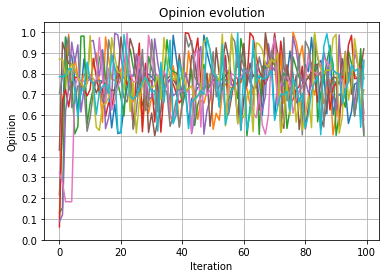

In [13]:
plt.plot(next_state_random_jumps(uniform.rvs(0, 1, size=10), 0.2, 0.5, 100))
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Opinion')
plt.title('Opinion evolution')
plt.yticks(np.linspace(0, 1, 11))
plt.show()

In [48]:
maxit = 200
alpha = [0.005, 0.005]
an1 = next_state_additive_noise(x0, 0.27, *alpha, maxit)
an2 = next_state_additive_noise(x0, 0.24, *alpha, maxit)
an3 = next_state_additive_noise(x0, 0.2, *alpha, maxit)
an4 = next_state_additive_noise(x0, 0.13, *alpha, maxit)

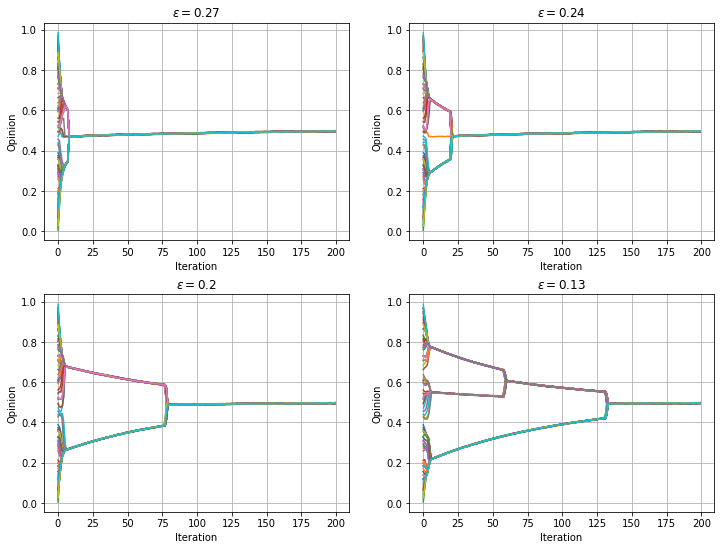

In [50]:
an = [[an1, an2], [an3, an4]]
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
plt.subplots_adjust(hspace=0.25)
for i in range(2):
    for j in range(2):
        ax[i][j].plot(an[i][j])
        ax[i][j].grid(True)
        ax[i][j].set_xlabel('Iteration')
        ax[i][j].set_ylabel('Opinion')
ax[0][0].set_title('$\\varepsilon=0.27$')
ax[0][1].set_title('$\\varepsilon=0.24$')
ax[1][0].set_title('$\\varepsilon=0.2$')
ax[1][1].set_title('$\\varepsilon=0.13$')
plt.show()

In [51]:
maxit = 200
alpha = [0.008, 0.002]
an5 = next_state_additive_noise(x0, 0.27, *alpha, maxit)
an6 = next_state_additive_noise(x0, 0.24, *alpha, maxit)
an7 = next_state_additive_noise(x0, 0.2, *alpha, maxit)
an8 = next_state_additive_noise(x0, 0.13, *alpha, maxit)

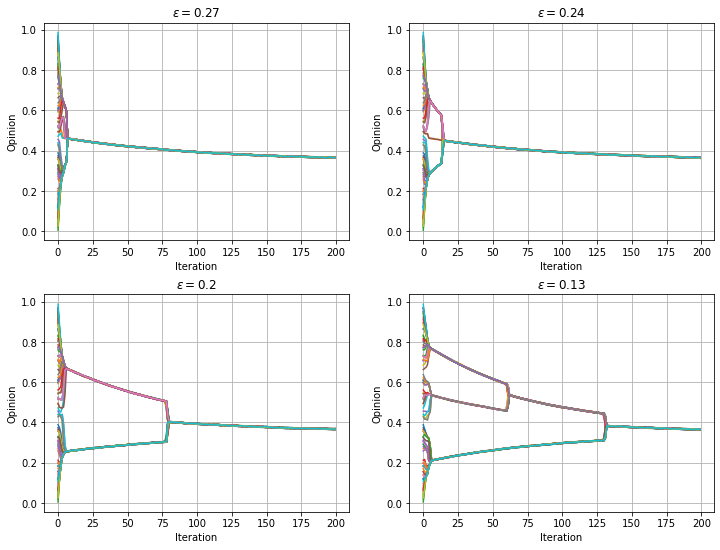

In [110]:
ann = [[an5, an6], [an7, an8]]
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
plt.subplots_adjust(hspace=0.25)
for i in range(2):
    for j in range(2):
        ax[i][j].plot(ann[i][j])
        ax[i][j].grid(True)
        ax[i][j].set_xlabel('Iteration')
        ax[i][j].set_ylabel('Opinion')
ax[0][0].set_title('$\\varepsilon=0.27$')
ax[0][1].set_title('$\\varepsilon=0.24$')
ax[1][0].set_title('$\\varepsilon=0.2$')
ax[1][1].set_title('$\\varepsilon=0.13$')
plt.show()

# Параметр порядка $Q(t)=\dfrac{1}{n^2}\sum\limits_{i=1}^n\sum\limits_{j=1}^n\mathbb{1}_{\{|x_i(t)-x_j(t)|\leqslant\varepsilon\}}$

In [64]:
def Q_t(t, next_state_additive_noise, eps):
    an = next_state_additive_noise
    n = len(x0)
    Q = 0
    for i in range(n):
        for j in range(n):
            ind = (np.abs(an[t][i] - an[t][j]) <= eps)
            Q += ind
    return Q / (n**2)

In [68]:
def Q(x0, eps, alpha1, alpha2, maxit):
    an = next_state_additive_noise(x0, eps, alpha1, alpha2, maxit)
    arr_Q = []
    for t in range(maxit):
        arr_Q.append(Q_t(t, an, eps))
    return np.array(arr_Q)

In [74]:
def avg_Q(x0, eps, alpha1, alpha2, maxit, MK):
    avg_Q = 0
    for i in trange(MK):
        avg_Q += Q(x0, eps, alpha1, alpha2, maxit)
    return avg_Q / n

Варьируем $\alpha^0$ при фиксированном $\varepsilon=0.2$

In [96]:
Q_alpha0 = []
alpha0 = np.linspace(0.1, 0.9, 9)
for a in alpha0:
    Q_alpha0.append(avg_Q(x0, 0.2, a/2, a/2, 100, 100))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:41<00:00,  2.81s/it]


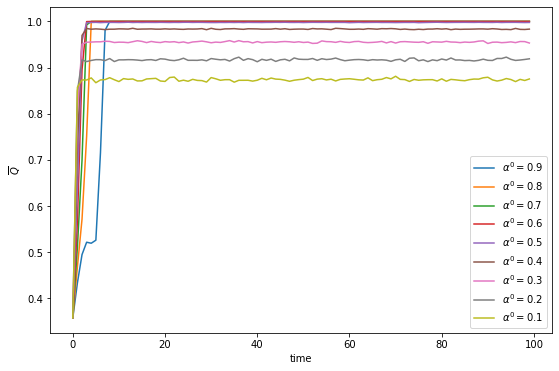

In [146]:
plt.figure(figsize=(9, 6))
for i in range(len(alpha0)):    
    plt.plot(Q_alpha0[i], label=f'$\\alpha^0=${round(alpha0[abs(i-len(alpha0)+1)], 1)}')
plt.xlabel('time')
plt.ylabel('$\overline{Q}$')
plt.legend()
plt.show()

Варьируем $\varepsilon$ при фиксированном $\alpha^0=0.4$ 

In [97]:
Q_eps = []
epsilon = np.linspace(0.1, 0.9, 9)
a = 0.4
for e in epsilon:
    Q_eps.append(avg_Q(x0, e, a/2, a/2, 100, 100))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:22<00:00,  3.23s/it]


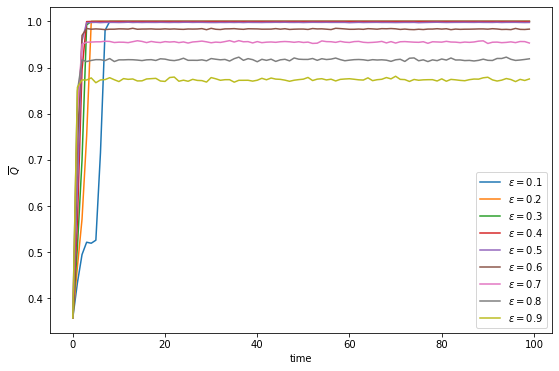

In [100]:
plt.figure(figsize=(9, 6))
for i in range(len(epsilon)):    
    plt.plot(Q_alpha0[i], label=f'$\\varepsilon=${round(epsilon[i], 1)}')
plt.xlabel('time')
plt.ylabel('$\overline{Q}$')
plt.legend()
plt.show()

# Количество агентов выше 0.5

In [113]:
np.random.seed(42)
x0 = uniform.rvs(0, 1, 10)

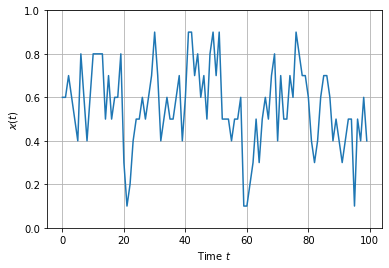

In [124]:
plt.plot(np.sum(next_state_additive_noise(x0, 0.2, 0.2, 0.2, 100)>0.5, axis=1) / len(x0))
plt.grid()
plt.xlabel('Time $t$')
plt.ylabel('$\\varkappa(t)$')
plt.ylim(0, 1)
plt.show()

In [125]:
def avg(N, alpha1, alpha2):
    stats = []
    for _ in trange(N):
        stats.append(np.sum(next_state_additive_noise(x0, eps, alpha1, alpha2, 100)>0.5, axis=1) / len(x0))
    stats = np.mean(stats, axis=0)
    return stats

In [126]:
eps = 0.2
stat = [avg(500, 0.3, 0.3), avg(500, 0.4, 0.2), avg(500, 0.2, 0.4)]

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:20<00:00, 24.67it/s]


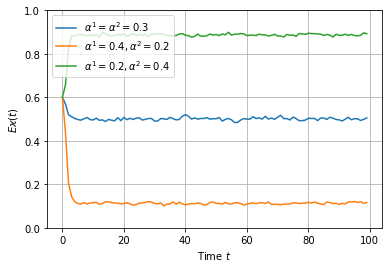

In [127]:
label=['$\\alpha^1=\\alpha^2=0.3$', '$\\alpha^1=0.4, \\alpha^2=0.2$', '$\\alpha^1=0.2, \\alpha^2=0.4$']
for i in range(3):
    plt.plot(stat[i], label=label[i])
plt.grid()
plt.xlabel('Time $t$')
plt.ylabel('$E\\varkappa (t)$')
plt.ylim(0, 1)
plt.legend()
plt.show()

# Асимптотическая нормальность сечений $\varkappa(t)$

In [14]:
def avg_t(N, t, alpha1, alpha2):
    stats = []
    for _ in trange(N):
        state = next_state_additive_noise(x0, 0.2, alpha1, alpha2, t)
        stats.append(sum(state[-1]>0.5) / len(x0))
    return stats

In [15]:
prop80, prop100, prop200 = avg_t(500, 80, 0.3, 0.3), avg_t(500, 100, 0.3, 0.3), avg_t(500, 200, 0.3, 0.3)

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [2:23:30<00:00, 17.22s/it]


In [16]:
prop80, prop100, prop200 = np.array(prop80), np.array(prop100), np.array(prop200)

In [17]:
print(prop80.mean(), prop80.std(ddof=1))
print(prop100.mean(), prop100.std(ddof=1))
print(prop200.mean(), prop200.std(ddof=1))

0.50222 0.05172836017595171
0.49642000000000003 0.05606129983042986
0.50014 0.05218454611958808


# t=80

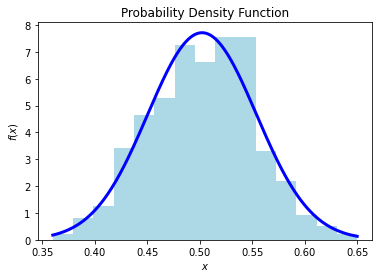

In [18]:
plt.hist(prop80, bins='auto', density=True, color='lightblue')
xs = np.linspace(min(prop80), max(prop80), 300)
ys = norm(loc=prop80.mean(), scale=prop80.std(ddof=1)).pdf(xs)
plt.plot(xs, ys, lw=3, color='blue')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title('Probability Density Function')
plt.show()

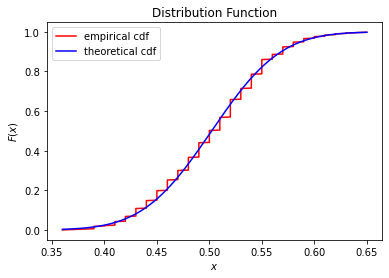

In [19]:
x = np.sort(prop80)
y = np.arange(len(x)) / len(x)
xs = np.linspace(min(prop80), max(prop80), 300)
ys = norm(loc=prop80.mean(), scale=prop80.std(ddof=1)).cdf(xs)
plt.plot(x, y, color='red', label='empirical cdf')
plt.plot(xs, ys, color='blue', label='theoretical cdf')
plt.xlabel('$x$')
plt.ylabel('$F(x)$')
plt.title('Distribution Function')
plt.legend()
#     plt.savefig('cdf.jpg')
plt.show()

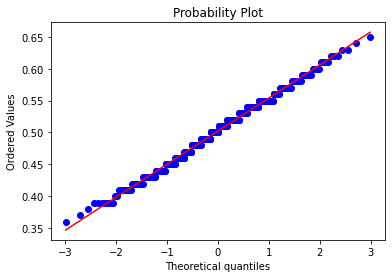

In [20]:
stats.probplot(prop80, dist='norm', plot=plt);

In [21]:
stats.kstest(prop80, 'norm', args=(prop80.mean(), prop80.std(ddof=1)))

KstestResult(statistic=0.06447104247176927, pvalue=0.029944994224102905)

# t=100

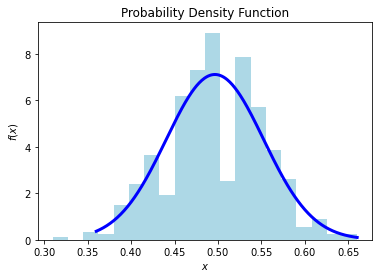

In [22]:
# plt.figure(dpi=300)
plt.hist(prop100, bins='auto', density=True, color='lightblue')
xs = np.linspace(min(prop80), max(prop100), 300)
ys = norm(loc=prop100.mean(), scale=prop100.std(ddof=1)).pdf(xs)
plt.plot(xs, ys, lw=3, color='blue')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title('Probability Density Function')
# plt.savefig('pdf100')
plt.show()

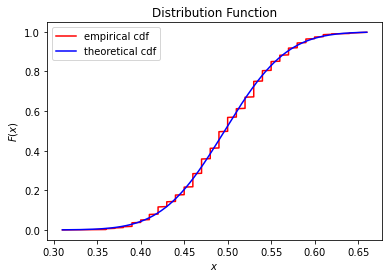

In [23]:
# plt.figure(dpi=300)
x = np.sort(prop100)
y = np.arange(len(x)) / len(x)
xs = np.linspace(min(prop100), max(prop100), 300)
ys = norm(loc=prop100.mean(), scale=prop100.std(ddof=1)).cdf(xs)
plt.plot(x, y, color='red', label='empirical cdf')
plt.plot(xs, ys, color='blue', label='theoretical cdf')
plt.xlabel('$x$')
plt.ylabel('$F(x)$')
plt.title('Distribution Function')
plt.legend()
# plt.savefig('cdf100.jpg')
plt.show()

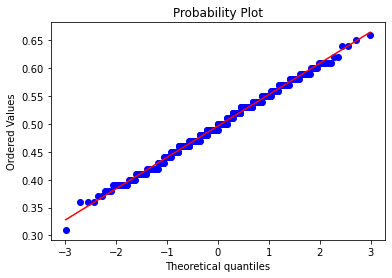

In [24]:
# plt.figure(dpi=300)
stats.probplot(prop100, dist='norm', plot=plt);
# plt.savefig('QQ100.jpg')

In [25]:
stats.kstest(prop100, 'norm', args=(prop100.mean(), prop100.std(ddof=1)))

KstestResult(statistic=0.05340928383658505, pvalue=0.11127570895592309)

# t=200

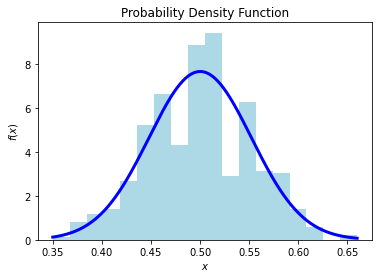

In [26]:
# plt.figure(dpi=300)
plt.hist(prop200, bins='auto', density=True, color='lightblue')
xs = np.linspace(min(prop200), max(prop200), 300)
ys = norm(loc=prop200.mean(), scale=prop200.std(ddof=1)).pdf(xs)
plt.plot(xs, ys, lw=3, color='blue')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title('Probability Density Function')
# plt.savefig('pdf200')
plt.show()

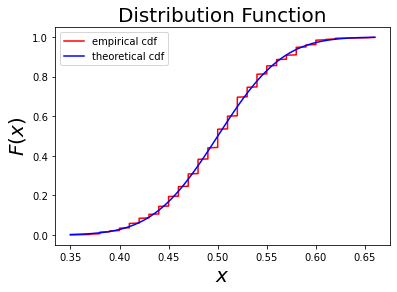

In [27]:
# plt.figure(dpi=200)
x = np.sort(prop200)
y = np.arange(len(x)) / len(x)
xs = np.linspace(min(prop200), max(prop200), 300)
ys = norm(loc=prop200.mean(), scale=prop200.std(ddof=1)).cdf(xs)
plt.plot(x, y, color='red', label='empirical cdf')
plt.plot(xs, ys, color='blue', label='theoretical cdf')
plt.xlabel('$x$', fontsize=20)
plt.ylabel('$F(x)$', fontsize=20)
plt.title('Distribution Function', fontsize=20)
plt.legend()
# plt.savefig('cdf200.jpg')
plt.show()

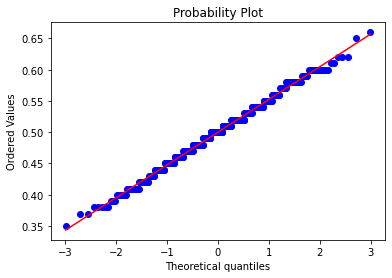

In [28]:
# plt.figure(dpi=300)
stats.probplot(prop200, dist='norm', plot=plt);
# plt.savefig('QQ200')

In [29]:
stats.kstest(prop200, 'norm', args=(prop200.mean(), prop200.std(ddof=1)))

KstestResult(statistic=0.05692972428790094, pvalue=0.07526228205349472)

# Зависимость диаметра притягивающего множества от $\alpha^0$

In [34]:
np.random.seed(42)
x0 = uniform.rvs(0, 1, size=10)

In [37]:
def diameter(t_max, eps, coef1, coef2):
    d = [] # ширина трубки
    for i in range(1, 10):
        alpha = 1 - i / 10
        state = next_state_additive_noise(x0, eps, coef1 * alpha, coef2 * alpha, t_max)
        d_i = [] # среднее значение трубки для одного значения параметров
        for j in range(t_max): #maxit=30
            d_i.append(max(state[j]) - min(state[j]))
        d_i = np.mean(d_i)
        d.append(d_i)
    return d

In [44]:
t_max = [50, 100, 150, 200, 250, 300]
d = []
d1 = []
d2 = []
for i in range(len(t_max)):
    for _ in trange(t_max[i]):
        d.append(diameter(t_max[i], 0.2, 0.5, 0.5))
        d1.append(diameter(t_max[i], 0.2, 0.9, 0.1))
        d2.append(diameter(t_max[i], 0.2, 0.3, 0.7))

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [11:05<00:00,  2.22s/it]


In [62]:
d50 = np.mean(d[:50], axis=0)
d100 = np.mean(d[50:150], axis=0)
d150 = np.mean(d[150:300], axis=0)
d200 = np.mean(d[300:500], axis=0)
d250 = np.mean(d[500:750], axis=0)
d300 = np.mean(d[750:1050], axis=0)

In [85]:
diameter = np.array([d50, d100, d150, d200, d250, d300])
diameter1 = np.array([np.mean(d1[:50], axis=0), np.mean(d1[50:150], axis=0), np.mean(d1[150:300], axis=0), np.mean(d1[300:500], axis=0), np.mean(d1[500:750], axis=0), np.mean(d1[750:1050], axis=0)])
diameter2 = np.array([np.mean(d2[:50], axis=0), np.mean(d2[50:150], axis=0), np.mean(d2[150:300], axis=0), np.mean(d2[300:500], axis=0), np.mean(d2[500:750], axis=0), np.mean(d2[750:1050], axis=0)])

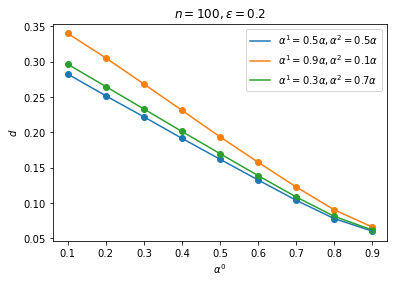

In [87]:
plt.scatter(np.linspace(0.1, 0.9, 9), d150)
plt.plot(np.linspace(0.1, 0.9, 9), d150, label=r'$\alpha^1=0.5\alpha, \alpha^2=0.5\alpha$')
plt.scatter(np.linspace(0.1, 0.9, 9), diameter1[2])
plt.plot(np.linspace(0.1, 0.9, 9), diameter1[2], label=r'$\alpha^1=0.9\alpha, \alpha^2=0.1\alpha$')
plt.scatter(np.linspace(0.1, 0.9, 9), diameter2[2])
plt.plot(np.linspace(0.1, 0.9, 9), diameter2[2], label=r'$\alpha^1=0.3\alpha, \alpha^2=0.7\alpha$')
plt.xlabel(r'$\alpha^0$')
plt.ylabel('$d$')
plt.title('$n=100, \\varepsilon=0.2$')
plt.legend()
plt.show()

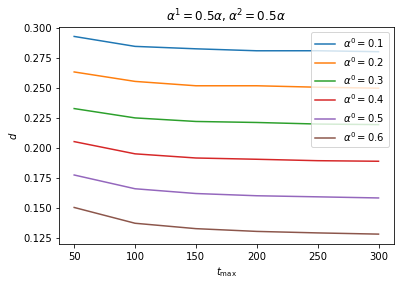

In [93]:
label = ['$\\alpha^0=0.1$', '$\\alpha^0=0.2$', '$\\alpha^0=0.3$', '$\\alpha^0=0.4$', '$\\alpha^0=0.5$', '$\\alpha^0=0.6$','$\\alpha^0=0.7$','$\\alpha^0=0.8$','$\\alpha^0=0.9$']
for i in range(len(t_max)):
    plt.plot(t_max, diameter[:, i], label=label[i])
plt.xlabel('$t_{\max}$')
plt.ylabel('$d$')
plt.title(r'$\alpha^1=0.5\alpha, \alpha^2=0.5\alpha$')
plt.legend()
plt.show()

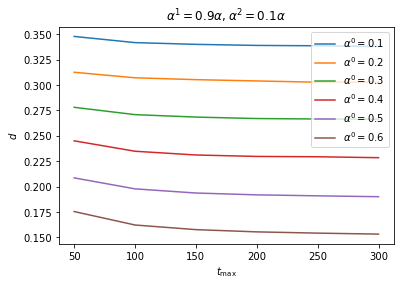

In [92]:
for i in range(len(t_max)):
    plt.plot(t_max, diameter1[:, i], label=label[i])
plt.xlabel('$t_{\max}$')
plt.ylabel('$d$')
plt.title(r'$\alpha^1=0.9\alpha, \alpha^2=0.1\alpha$')
plt.legend()
plt.show()

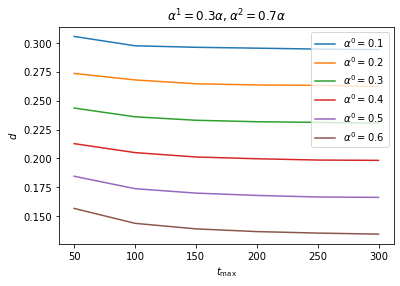

In [94]:
for i in range(len(t_max)):
    plt.plot(t_max, diameter2[:, i], label=label[i])
plt.xlabel('$t_{\max}$')
plt.ylabel('$d$')
plt.title(r'$\alpha^1=0.3\alpha, \alpha^2=0.7\alpha$')
plt.legend()
plt.show()

# Плотность распределения мнений

In [53]:
def rho(N, eps, alpha1, alpha2):
    rho200 = next_state_additive_noise(x0, eps, alpha1, alpha2, 200)[199]
    rho500 = next_state_additive_noise(rho200, eps, alpha1, alpha2, 300)[299]
    rho1000 = next_state_additive_noise(rho500, eps, alpha1, alpha2, 500)[499]
    rho2000 = next_state_additive_noise(rho2000, eps, alpha1, alpha2, 1000)[999]
    rho4000 = next_state_additive_noise(rho3000, eps, alpha1, alpha2, 1000)[999]
    rho5000 = next_state_additive_noise(rho4000, eps, alpha1, alpha2, 1000)[999]
    delta = []
    for i in range(N):
        delta.append([i/N, (i+1)/N])
    s200 = []
    s500 = []
    s1000 = []
    s2000 = []
    s3000 = []
    s4000 = []
    s5000 = []
    for d in delta:
        s200.append(sum((rho200 <= d[1]) & (rho200 >=d[0])))
        s500.append(sum((rho500 <= d[1]) & (rho500 >=d[0])))
        s1000.append(sum((rho1000 <= d[1]) & (rho1000 >=d[0])))
        s2000.append(sum((rho2000 <= d[1]) & (rho2000 >=d[0])))
        s3000.append(sum((rho3000 <= d[1]) & (rho3000 >=d[0])))
        s4000.append(sum((rho4000 <= d[1]) & (rho4000 >=d[0])))
        s5000.append(sum((rho5000 <= d[1]) & (rho5000 >=d[0])))
    return (s200, s500, s1000, s2000, s3000, s4000, s5000)

In [55]:
rho1 = rho(20, 0.2, 0.005, 0.005)
rho2 = rho(20, 0.27, 0.005, 0.005)

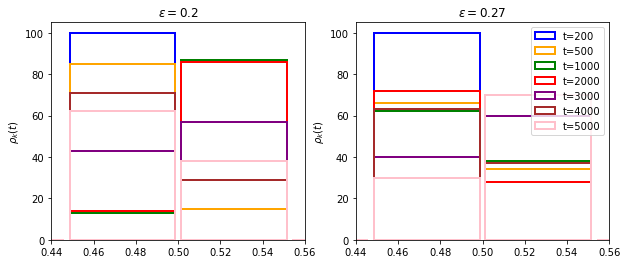

In [60]:
N = 20
label = ['t=200', 't=500', 't=1000', 't=2000', 't=3000', 't=4000', 't=5000']
color = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i in range(len(rho1)):
    ax[0].bar(np.linspace(0, 1, N), rho1[i], color='none', width=1/N, linewidth=2, edgecolor=color[i])
    ax[0].set_ylabel('$\\rho_k(t)$')
    ax[0].set_title('$\\varepsilon=0.2$')
    ax[0].set_xlim(0.44, 0.56)
for i in range(len(rho2)):
    ax[1].bar(np.linspace(0, 1, N), rho2[i], color='none', width=1/N, linewidth=2, edgecolor=color[i], label=label[i])
    ax[1].set_ylabel('$\\rho_k(t)$')
    ax[1].set_title('$\\varepsilon=0.27$')
    ax[1].set_xlim(0.44, 0.56)
ax[1].legend()
plt.show()

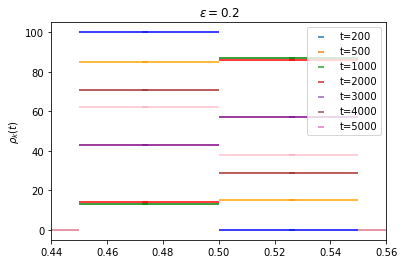

In [64]:
for i in range(len(rho1)):
    plt.scatter(np.linspace(0, 1, N), rho1[i], marker='_', label=label[i])
    for j in range(len(rho1[i])):
        plt.hlines(rho1[i][j], xmin=j/N, xmax=(j+1)/N, color=color[i])
plt.xlim(0.44, 0.56)
plt.ylabel('$\\rho_k(t)$')
plt.title('$\\varepsilon=0.2$')
plt.legend()
plt.show()

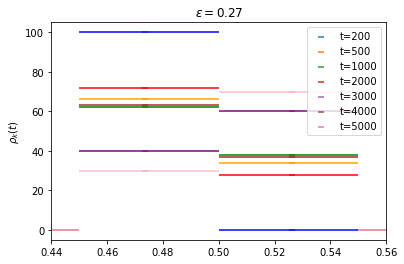

In [66]:
for i in range(len(rho2)):
    plt.scatter(np.linspace(0, 1, N), rho2[i], marker='_', label=label[i])
    for j in range(len(rho2[i])):
        plt.hlines(rho2[i][j], xmin=j/N, xmax=(j+1)/N, color=color[i])
plt.xlim(0.44, 0.56)
plt.ylabel('$\\rho_k(t)$')
plt.title('$\\varepsilon=0.27$')
plt.legend()
plt.show()

In [96]:
def time(x0, mu, eps):
    x0 = x0
    states = []
    T = 0
    flag = 0
    states.extend(x0)
    for i in range(maxit):
        for agent in range(10):
            x = find_state_model4(x0, agent, mu, eps)
            x0 = x
        states.extend(x)
        states_T = states[-10:]
        res = all([state >= 0.5 for state in states_T])
        if res == 1 and flag == 0:
            T = i
            flag += 1
    return (states, T)

states = np.reshape(time(x0, mu, eps)[0], (maxit+1, 1000))
agents = np.transpose(states)

In [161]:
def find_T(mu, x0):
    T = []
    for i in trange(200):
        T.append(time(x0, mu, eps)[1])
    return T

In [163]:
mu_values = np.linspace(0.1, 0.9, 9)
T = []
for mu in mu_values:
    T.append(find_T(mu, [0.40768703, 0.05536604, 0.078853488, 0.28730518, 0.45035059, 0.30391231, 0.52639952, 0.62381221, 0.077677546, 0.068624165]
))

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.71it/s]


In [164]:
mean_T = []
for elem in T:
    mean_T.append(np.mean(elem))
mean_T

[19.46, 8.84, 5.32, 3.8, 2.635, 1.86, 1.55, 1.215, 0.63]

In [165]:
mu_values1 = np.linspace(0.1, 0.9, 9)
T1 = []
for mu in mu_values1:
    T1.append(find_T(mu, [0.04037063, 0.36922015, 0.22065461, 0.07915493, 0.43996852, 0.13704323, 0.20711751, 0.14803997, 0.31439395, 0.28991891]
))

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:17<00:00, 11.50it/s]


In [166]:
mean_T1 = []
for elem in T1:
    mean_T1.append(np.mean(elem))
mean_T1

[27.105, 12.455, 7.77, 5.27, 3.555, 2.735, 1.865, 1.37, 0.835]

# $x(0) \sim U(0, 0.5)$

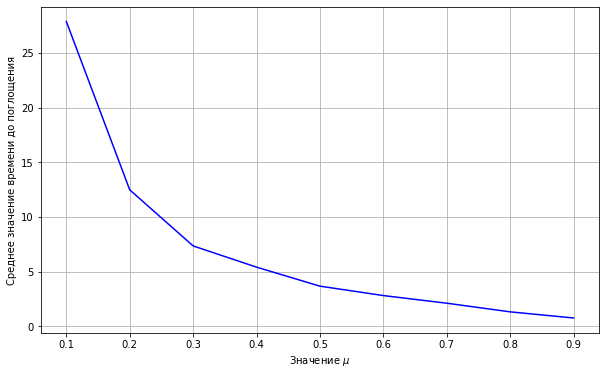

In [414]:
plt.figure(figsize=(10, 6))
plt.plot(mu_values1, mean_T1, c='blue')
# plt.yticks(mean_T)
plt.grid()
plt.xlabel('Значение $\mu$')
plt.ylabel('Среднее значение времени до поглощения')
plt.show()

# $x(0) \sim U(0, 1)$

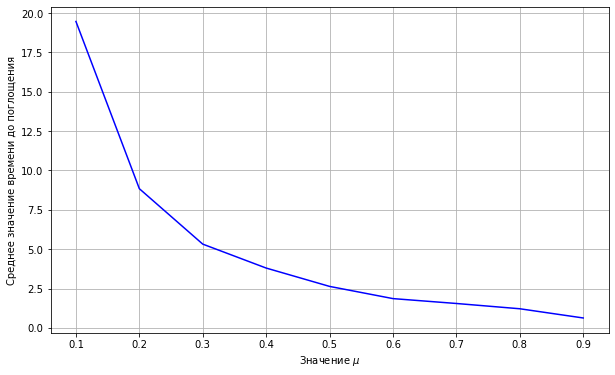

In [167]:
plt.figure(figsize=(10, 6))
plt.plot(mu_values, mean_T, c='blue')
# plt.yticks(mean_T)
plt.grid()
plt.xlabel('Значение $\mu$')
plt.ylabel('Среднее значение времени до поглощения')
plt.show()

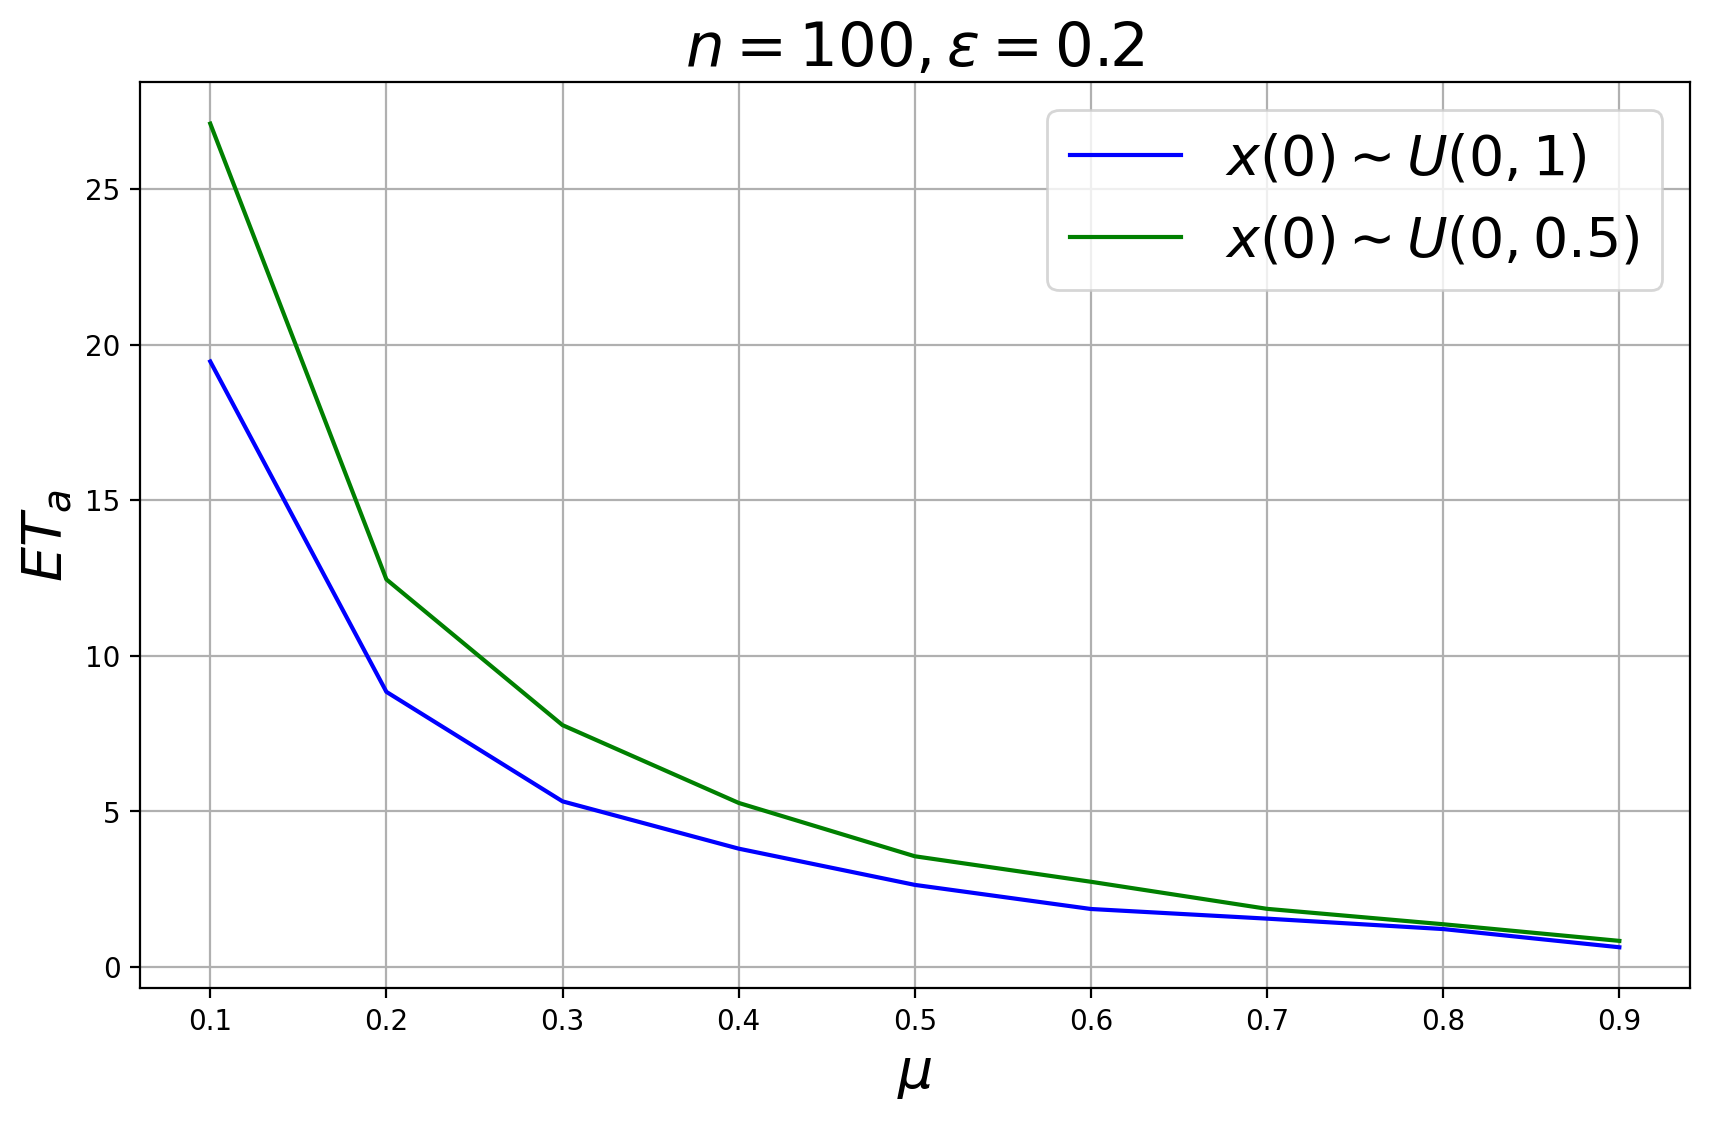

In [190]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
ax.plot(mu_values, mean_T, color='blue', label='$x(0)\sim U(0, 1)$')
ax.plot(mu_values1, mean_T1, color='green', label='$x(0)\sim U(0, 0.5)$')
plt.grid()
plt.xlabel('$\mu$', fontsize=20)
plt.ylabel('$ET_a$', fontsize=20)
plt.title('$n=100, \\varepsilon=0.2$', fontsize=22)
ax.legend(fontsize=20)
# plt.savefig('mu.png')
plt.show()

In [178]:
def find_eps(eps, x0):
    E = []
    for i in trange(100):
        E.append(time(x0, 0.5, eps)[1])
    return E

In [464]:
np.random.seed(10)
uniform.rvs(0, 1, 10)
uniform.rvs(0, 0.5, 10)

array([0.34267991, 0.47669667, 0.00197413, 0.25609613, 0.40631048,
       0.30626303, 0.36087766, 0.14593803, 0.45888706, 0.35728789])

In [179]:
eps_values = np.linspace(0.1, 0.9, 9)
E = []

for eps in eps_values:
    E.append(find_eps(eps, [0.77132064, 0.02075195, 0.63364823, 0.74880388, 0.49850701,
       0.22479665, 0.19806286, 0.76053071, 0.16911084, 0.08833981]))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.34it/s]


In [180]:
mean_T2 = []
for elem in E:
    mean_T2.append(np.mean(elem))
mean_T2

[3.0, 3.22, 2.94, 1.62, 1.51, 1.17, 1.04, 1.08, 1.06]

In [181]:
eps_values1 = np.linspace(0.1, 0.9, 9)
E1 = []

for eps in eps_values1:
    E1.append(find_eps(eps, [0.34267991, 0.47669667, 0.00197413, 0.25609613, 0.40631048,
       0.30626303, 0.36087766, 0.14593803, 0.45888706, 0.35728789]))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.32it/s]


In [182]:
mean_T3 = []
for elem in E1:
    mean_T3.append(np.mean(elem))
mean_T3

[3.75, 3.17, 2.22, 1.69, 1.39, 1.12, 1.05, 1.05, 1.0]

# Начальный профиль $x \sim U(0, 1)$

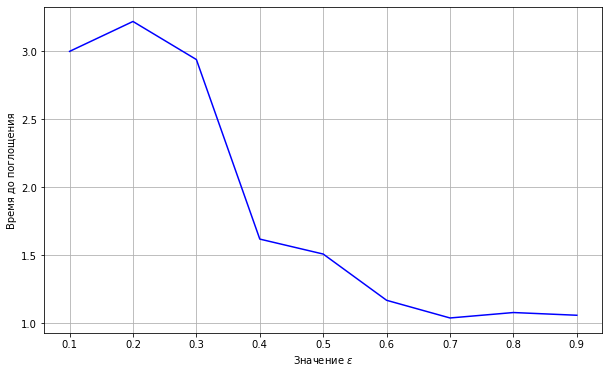

In [183]:
plt.figure(figsize=(10, 6))
plt.plot(eps_values, mean_T2, c='blue')
plt.grid()
plt.xlabel('Значение $\epsilon$')
plt.ylabel('Время до поглощения')
plt.show()

#  $x(0) \sim U(0, 0.5)$

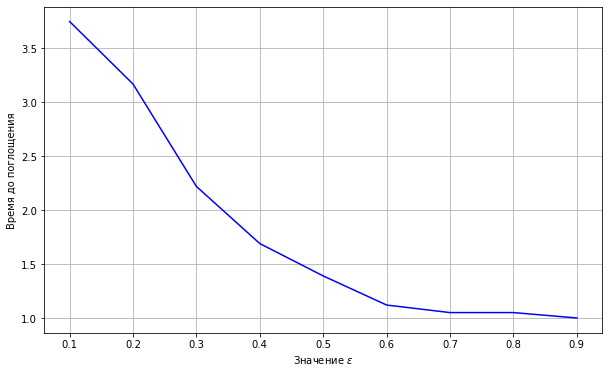

In [184]:
plt.figure(figsize=(10, 6))
plt.plot(eps_values1, mean_T3, c='blue')
plt.grid()
plt.xlabel('Значение $\epsilon$')
plt.ylabel('Время до поглощения')
plt.show()

In [17]:
beta1 = 0.5
beta2 = 1 - beta1

In [18]:
def find_state_model5(x, j, mu, eps):
    states = []
    neighbours = []
    n = bernoulli.rvs(mu, loc=0, size=1)
    n = n[0]
    if n == 0:
        if len(f(j, x, eps)[1]) != 0:
            x[j] = sum(f(j, x, eps)[1]) / f(j, x, eps)[0]
        else:
            x[j] = x[j]
    elif n == 1:
        gamma = np.random.choice([1, -1], size=1, p=[beta1, beta2])
        gamma = gamma[0]
        if gamma == 1:
            noise = np.random.uniform(0.5, 1)
            x = np.delete(x, j)
            x = np.insert(x, j, noise)
        elif gamma == -1:
            noise = np.random.uniform(0, 0.5)
            x = np.delete(x, j)
            x = np.insert(x, j, noise)
    return x

In [39]:
def time1(x0, mu, eps):
    x0 = x0
    states = []
    T = 0
    flag = 0
#     time = []
    states.extend(x0)
    for i in range(maxit):
        for agent in range(10):
            x = find_state_model5(x0, agent, mu, eps)
            x0 = x
        states.extend(x)
    return states

states = np.reshape(time1(x0, mu, eps), (maxit+1, 10))
agents = np.transpose(states)

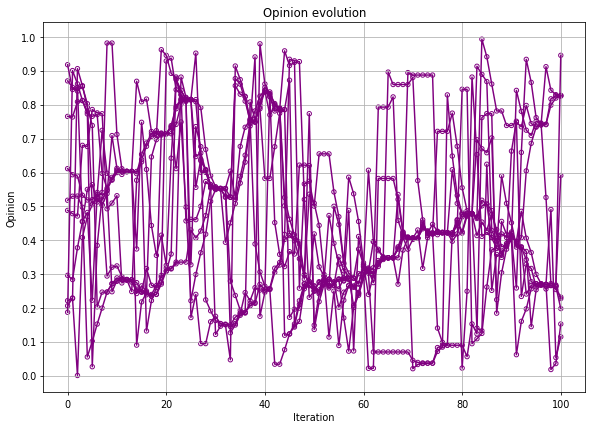

In [14]:
fig, ax = plt.subplots(figsize=(10, 7), dpi=70)
for i in range(10):
    ax.plot(np.arange(maxit+1), agents[i], c='purple')
    ax.scatter(np.arange(maxit+1), agents[i], s=20, facecolors='none', edgecolors='purple')
plt.grid(True)
plt.yticks(np.linspace(0.0, 1.0, 11))
plt.xlabel('Iteration')
plt.ylabel('Opinion')
plt.title('Opinion evolution')
plt.show()